In [17]:
import numpy as np
import pandas as pan
import matplotlib.pyplot as plot
%matplotlib inline
import itertools
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import absolute
from numpy import sqrt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler

diab = pan.read_csv(r'C:\Users\kstre_3ikvnbf\STAT 4360\Mini Project 2\diabetes.csv')
print(diab)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

In [4]:
diab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
diab_copy = diab.copy(deep = True)
diab_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diab_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

# Showing the Count of NANs
print(diab_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [9]:
diab_copy['Glucose'].fillna(diab_copy['Glucose'].mean(), inplace = True)
diab_copy['BloodPressure'].fillna(diab_copy['BloodPressure'].mean(), inplace = True)
diab_copy['SkinThickness'].fillna(diab_copy['SkinThickness'].median(), inplace = True)
diab_copy['Insulin'].fillna(diab_copy['Insulin'].median(), inplace = True)
diab_copy['BMI'].fillna(diab_copy['BMI'].median(), inplace = True)
# Scale Data
sc_X = StandardScaler()
X =  pan.DataFrame(sc_X.fit_transform(diab_copy.drop(["Outcome"],axis = 1),), columns=['Pregnancies', 
'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.865108,-0.033518,0.670643,-0.181541,0.166619,0.468492,1.425995
1,-0.844885,-1.206162,-0.529859,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672
2,1.233880,2.015813,-0.695306,-0.012301,-0.181541,-1.332500,0.604397,-0.105584
3,-0.844885,-1.074652,-0.529859,-0.695245,-0.540642,-0.633881,-0.920763,-1.041549
4,-1.141852,0.503458,-2.680669,0.670643,0.316566,1.549303,5.484909,-0.020496


In [19]:
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=7)

lr = LogisticRegression()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

#view mean absolute error
lr_test = mean(absolute(scores))
lr_test

0.2328054298642534

In [75]:
lr.fit(X_train, y_train)
print(lr.intercept_, lr.coef_, lr.score(X, y))

[-0.95518469] [[ 0.25350886  1.11927869 -0.05175129  0.18897269 -0.05855058  0.5189645
   0.22133363  0.28490366]] 0.7682291666666666


In [26]:
# Best Subset Selection
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    model = sm.Logit(y,X[list(feature_set)])
    regr = model.fit()
    RSS = ((regr.predict(X[list(feature_set)]) - y) ** 2).sum()
    return {"model":regr, "RSS":RSS}

def getBest(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset(combo)) 
    # Wrap everything up in a nice dataframe
    models = pan.DataFrame(results)
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_best = pan.DataFrame(columns=["RSS", "model"])

tic = time.time()
for i in range(1,9):
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Optimization terminated successfully.
         Current function value: 0.670238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666502
         Iterations 5
Processed 8 models on 1 predictors in 0.0861668586730957 seconds.
Optimization terminated successfully.
         Current function value: 0.555010
         Iterations 6
Optimization ter

Optimization terminated successfully.
         Current function value: 0.648671
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633166
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.645542
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635753
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.636156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619905
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.637812
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.626930
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.610817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638112
  

Optimization terminated successfully.
         Current function value: 0.538695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.547083
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.523276
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538817
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522563
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.529014
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.545629
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522952
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610493
  

Optimization terminated successfully.
         Current function value: 0.531071
         Iterations 6
Processed 8 models on 7 predictors in 0.08942532539367676 seconds.
Optimization terminated successfully.
         Current function value: 0.521695
         Iterations 6
Processed 1 models on 8 predictors in 0.012340784072875977 seconds.
Total elapsed time: 4.108493328094482 seconds.


In [27]:
models_best

,RSS,model
1,147.499139,<statsmodels.discrete.discrete_model.BinaryRes...
2,139.591116,<statsmodels.discrete.discrete_model.BinaryRes...
3,134.877625,<statsmodels.discrete.discrete_model.BinaryRes...
4,131.592176,<statsmodels.discrete.discrete_model.BinaryRes...
5,131.549086,<statsmodels.discrete.discrete_model.BinaryRes...
6,131.514347,<statsmodels.discrete.discrete_model.BinaryRes...
7,131.510359,<statsmodels.discrete.discrete_model.BinaryRes...
8,131.560776,<statsmodels.discrete.discrete_model.BinaryRes...


In [28]:
print(models_best.loc[1, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      767
Method:                           MLE   Df Model:                            0
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1199
Time:                        18:04:29   Log-Likelihood:                -437.18
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Glucose        1.1958      0.102     11.669      0.000       0.995       1.397


In [29]:
print(models_best.loc[2, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1574
Time:                        18:04:39   Log-Likelihood:                -418.58
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 7.171e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Glucose        1.1235      0.104     10.797      0.000       0.920       1.327
BMI            0.5412      0.093      5.831      0.000       0.359       0.723


In [30]:
print(models_best.loc[3, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1806
Time:                        18:04:47   Log-Likelihood:                -407.03
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.096e-39
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Pregnancies     0.4182      0.089      4.700      0.000       0.244       0.593
Glucose         1.0926      0.105     10.412      0.000       0.887       1.298
BMI             0.5590      0.095      5.907    

In [31]:
print(models_best.loc[4, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1910
Time:                        18:04:55   Log-Likelihood:                -401.88
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 6.979e-41
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.4347      0.090      4.829      0.000       0.258       0.611
Glucose                      1.0861      0.106     10.265      0.000       0.879       1.

In [32]:
print(models_best.loc[5, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      763
Method:                           MLE   Df Model:                            4
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1914
Time:                        18:05:03   Log-Likelihood:                -401.66
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 4.898e-40
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.4469      0.092      4.853      0.000       0.266       0.627
Glucose                      1.0974      0.108     10.201      0.000       0.887       1.

In [33]:
print(models_best.loc[6, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1922
Time:                        18:05:11   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.434e-39
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.3977      0.107      3.721      0.000       0.188       0.607
Glucose                      1.0799      0.109      9.894      0.000       0.866       1.

In [34]:
print(models_best.loc[7, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      761
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1922
Time:                        18:05:21   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.589e-38
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.3978      0.107      3.719      0.000       0.188       0.607
Glucose                      1.0800      0.109      9.886      0.000       0.866       1.

In [35]:
print(models_best.loc[8, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      760
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1934
Time:                        18:05:27   Log-Likelihood:                -400.66
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 5.238e-38
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.4010      0.107      3.731      0.000       0.190       0.612
Glucose                      1.1308      0.120      9.440      0.000       0.896       1.

Text(0, 0.5, 'BIC')

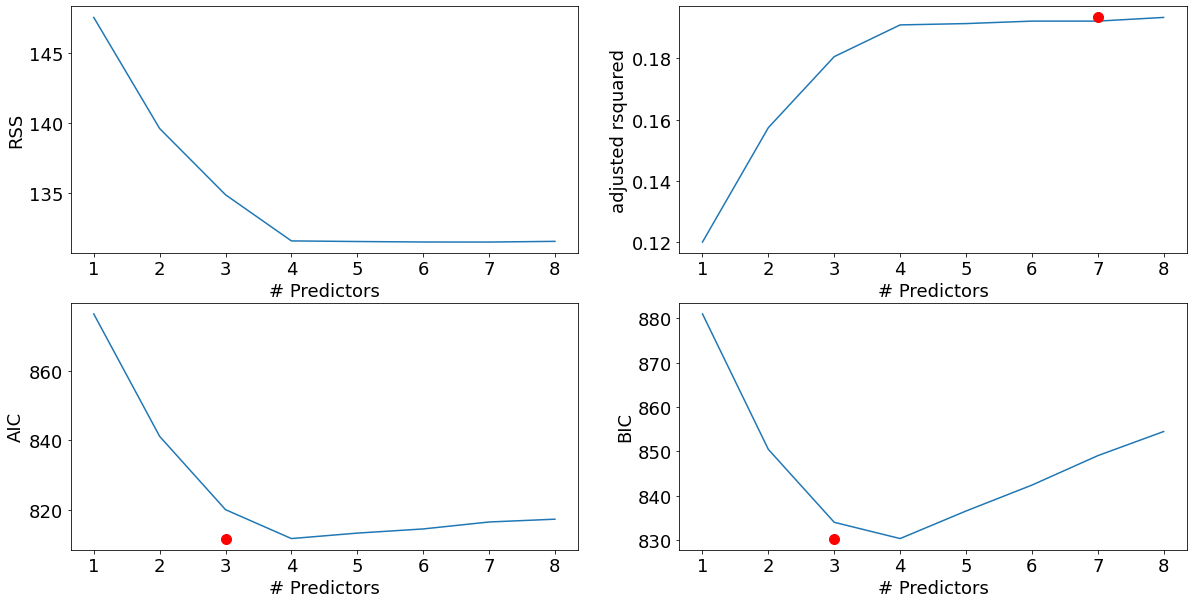

In [38]:
plot.figure(figsize=(20,10))
plot.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plot.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plot.plot(models_best["RSS"])
plot.xlabel('# Predictors')
plot.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_best.apply(lambda row: row[1].prsquared, axis=1)

plot.subplot(2, 2, 2)
plot.plot(rsquared_adj)
plot.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plot.xlabel('# Predictors')
plot.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_best.apply(lambda row: row[1].aic, axis=1)

plot.subplot(2, 2, 3)
plot.plot(aic)
plot.plot(aic.argmin(), aic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('AIC')

bic = models_best.apply(lambda row: row[1].bic, axis=1)

plot.subplot(2, 2, 4)
plot.plot(bic)
plot.plot(bic.argmin(), bic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('BIC')

In [43]:
# Test MSE for Model with 4 variables 
X = df[['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

model1 = LogisticRegression()
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)
model1_test = mean_squared_error(y_pred, y_test)
print("Test MSE = ", model1_test)

Test MSE =  0.2597402597402597


In [45]:
X =  pan.DataFrame(sc_X.fit_transform(diab_copy.drop(["Outcome"],axis = 1),), columns=['Pregnancies', 
'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

In [46]:
# Forward Stepwise Selection
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pan.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_fwd = pan.DataFrame(columns=["RSS", "model"])

tic = time.time()
predictors = []

for i in range(1,len(X.columns)+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Optimization terminated successfully.
         Current function value: 0.670238
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.569241
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680399
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671119
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.671821
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.646338
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.678880
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666502
         Iterations 5
Processed  8 models on 1 predictors in 0.07490205764770508 seconds.
Optimization terminated successfully.
         Current function value: 0.555010
         Iterations 6
Optimization t

In [47]:
print(models_fwd.loc[1, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      767
Method:                           MLE   Df Model:                            0
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1199
Time:                        18:21:41   Log-Likelihood:                -437.18
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Glucose        1.1958      0.102     11.669      0.000       0.995       1.397


In [48]:
print(models_fwd.loc[2, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1574
Time:                        18:22:01   Log-Likelihood:                -418.58
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 7.171e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Glucose        1.1235      0.104     10.797      0.000       0.920       1.327
BMI            0.5412      0.093      5.831      0.000       0.359       0.723


In [49]:
print(models_fwd.loc[3, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1806
Time:                        18:22:20   Log-Likelihood:                -407.03
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.096e-39
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Glucose         1.0926      0.105     10.412      0.000       0.887       1.298
BMI             0.5590      0.095      5.907      0.000       0.374       0.745
Pregnancies     0.4182      0.089      4.700    

In [50]:
print(models_fwd.loc[4, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1910
Time:                        18:22:21   Log-Likelihood:                -401.88
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 6.979e-41
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Glucose                      1.0861      0.106     10.265      0.000       0.879       1.293
BMI                          0.5373      0.095      5.633      0.000       0.350       0.

In [51]:
print(models_fwd.loc[5, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      763
Method:                           MLE   Df Model:                            4
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1914
Time:                        18:22:23   Log-Likelihood:                -401.66
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 4.898e-40
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Glucose                      1.0974      0.108     10.201      0.000       0.887       1.308
BMI                          0.5522      0.098      5.627      0.000       0.360       0.

In [52]:
print(models_fwd.loc[6, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1922
Time:                        18:22:24   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.434e-39
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Glucose                      1.0799      0.109      9.894      0.000       0.866       1.294
BMI                          0.5599      0.098      5.685      0.000       0.367       0.

In [53]:
print(models_fwd.loc[7, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      761
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1922
Time:                        18:22:26   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.589e-38
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Glucose                      1.0800      0.109      9.886      0.000       0.866       1.294
BMI                          0.5611      0.116      4.832      0.000       0.334       0.

In [54]:
print(models_fwd.loc[8, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      760
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1934
Time:                        18:22:27   Log-Likelihood:                -400.66
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 5.238e-38
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Glucose                      1.1308      0.120      9.440      0.000       0.896       1.366
BMI                          0.5763      0.118      4.905      0.000       0.346       0.

Text(0, 0.5, 'BIC')

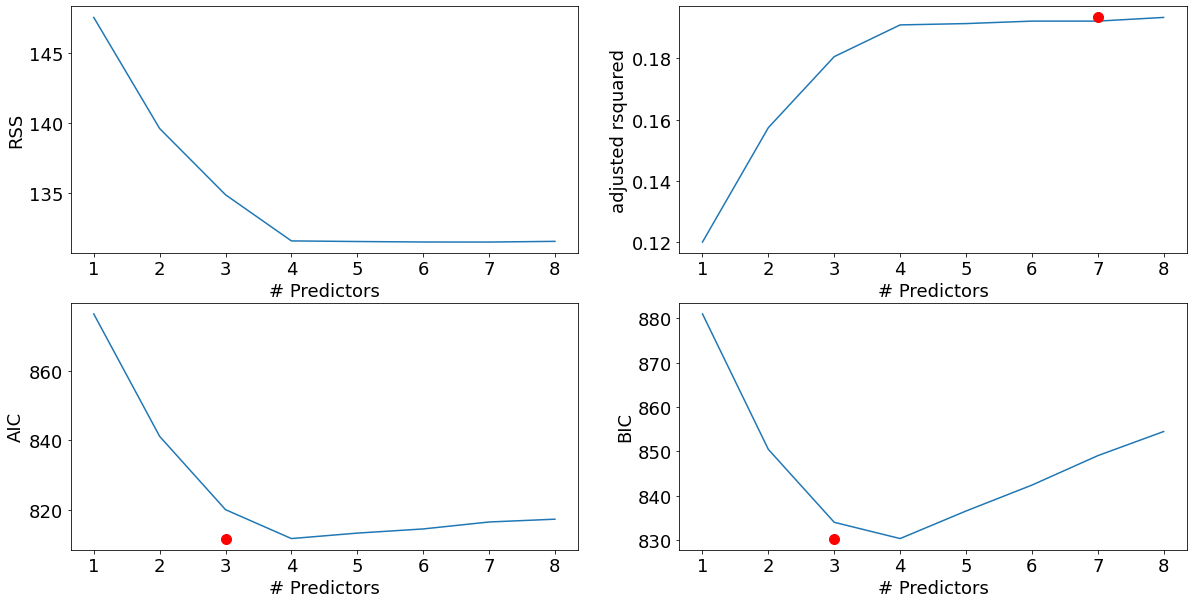

In [55]:
plot.figure(figsize=(20,10))
plot.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plot.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plot.plot(models_fwd["RSS"])
plot.xlabel('# Predictors')
plot.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_fwd.apply(lambda row: row[1].prsquared, axis=1)

plot.subplot(2, 2, 2)
plot.plot(rsquared_adj)
plot.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plot.xlabel('# Predictors')
plot.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_fwd.apply(lambda row: row[1].aic, axis=1)

plot.subplot(2, 2, 3)
plot.plot(aic)
plot.plot(aic.argmin(), aic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('AIC')

bic = models_fwd.apply(lambda row: row[1].bic, axis=1)

plot.subplot(2, 2, 4)
plot.plot(bic)
plot.plot(bic.argmin(), bic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('BIC')

In [57]:
# Test MSE for Model with 4 variables 
X = df[['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

model2 = LogisticRegression()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
model2_test = mean_squared_error(y_pred, y_test)
print("Test MSE = ", model2_test)

Test MSE =  0.2597402597402597


In [59]:
X =  pan.DataFrame(sc_X.fit_transform(diab_copy.drop(["Outcome"],axis = 1),), columns=['Pregnancies', 
'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

In [60]:
# Backwards Selection
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pan.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].argmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

models_bwd = pan.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Optimization terminated successfully.
         Current function value: 0.522215
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.528266
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.538581
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522475
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.521695
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.522252
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.596409
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.531071
         Iterations 6
Processed  8 models on 7 predictors in 0.04014945030212402 seconds.
Optimization terminated successfully.
         Current function value: 0.522997
         Iterations 6
Optimization t

In [61]:
print(models_bwd.loc[1, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      767
Method:                           MLE   Df Model:                            0
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1199
Time:                        18:28:25   Log-Likelihood:                -437.18
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Glucose        1.1958      0.102     11.669      0.000       0.995       1.397


In [62]:
print(models_bwd.loc[2, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      766
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1574
Time:                        18:28:53   Log-Likelihood:                -418.58
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 7.171e-36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Glucose        1.1235      0.104     10.797      0.000       0.920       1.327
BMI            0.5412      0.093      5.831      0.000       0.359       0.723


In [63]:
print(models_bwd.loc[3, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      765
Method:                           MLE   Df Model:                            2
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1806
Time:                        18:28:54   Log-Likelihood:                -407.03
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.096e-39
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Pregnancies     0.4182      0.089      4.700      0.000       0.244       0.593
Glucose         1.0926      0.105     10.412      0.000       0.887       1.298
BMI             0.5590      0.095      5.907    

In [64]:
print(models_bwd.loc[4, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      764
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1910
Time:                        18:28:56   Log-Likelihood:                -401.88
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 6.979e-41
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.4347      0.090      4.829      0.000       0.258       0.611
Glucose                      1.0861      0.106     10.265      0.000       0.879       1.

In [65]:
print(models_bwd.loc[5, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      763
Method:                           MLE   Df Model:                            4
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1914
Time:                        18:28:57   Log-Likelihood:                -401.66
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 4.898e-40
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.4469      0.092      4.853      0.000       0.266       0.627
Glucose                      1.0974      0.108     10.201      0.000       0.887       1.

In [66]:
print(models_bwd.loc[6, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      762
Method:                           MLE   Df Model:                            5
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1922
Time:                        18:28:59   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 2.434e-39
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.3977      0.107      3.721      0.000       0.188       0.607
Glucose                      1.0799      0.109      9.894      0.000       0.866       1.

In [67]:
print(models_bwd.loc[7, "model"].summary())

                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      761
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.1922
Time:                        18:29:00   Log-Likelihood:                -401.26
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 1.589e-38
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.3978      0.107      3.719      0.000       0.188       0.607
Glucose                      1.0800      0.109      9.886      0.000       0.866       1.

Text(0, 0.5, 'BIC')

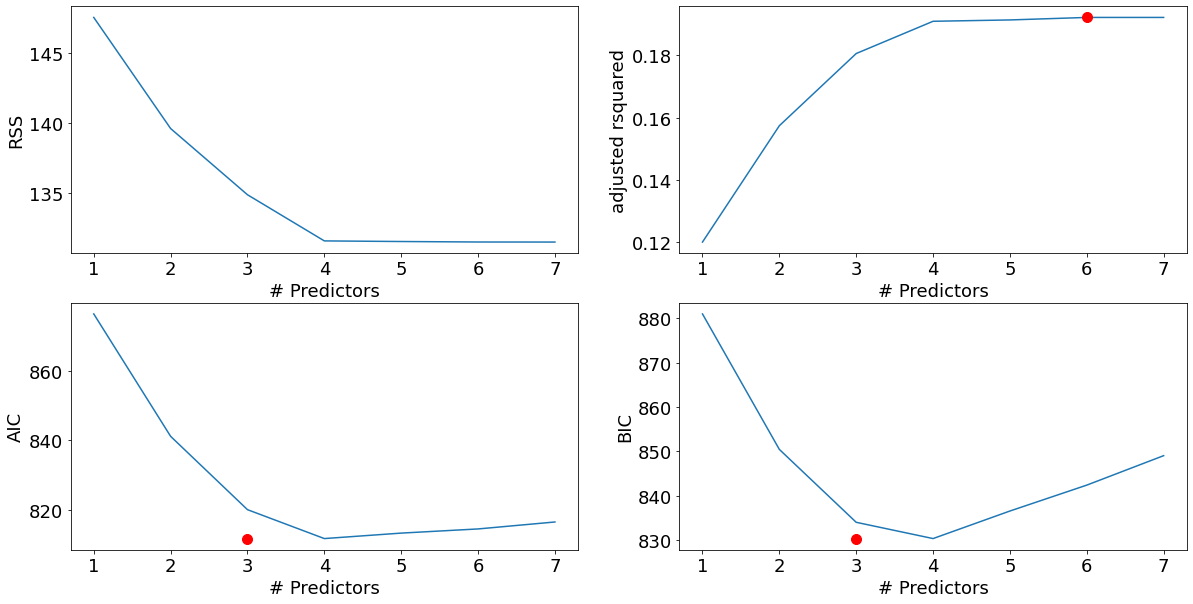

In [69]:
plot.figure(figsize=(20,10))
plot.rcParams.update({'font.size': 18, 'lines.markersize': 10})

# Set up a 2x2 grid so we can look at 4 plots at once
plot.subplot(2, 2, 1)

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector
plot.plot(models_bwd["RSS"])
plot.xlabel('# Predictors')
plot.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The argmax() function can be used to identify the location of the maximum point of a vector

rsquared_adj = models_bwd.apply(lambda row: row[1].prsquared, axis=1)

plot.subplot(2, 2, 2)
plot.plot(rsquared_adj)
plot.plot(rsquared_adj.argmax(), rsquared_adj.max(), "or")
plot.xlabel('# Predictors')
plot.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
aic = models_bwd.apply(lambda row: row[1].aic, axis=1)

plot.subplot(2, 2, 3)
plot.plot(aic)
plot.plot(aic.argmin(), aic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('AIC')

bic = models_bwd.apply(lambda row: row[1].bic, axis=1)

plot.subplot(2, 2, 4)
plot.plot(bic)
plot.plot(bic.argmin(), bic.min(), "or")
plot.xlabel('# Predictors')
plot.ylabel('BIC')

In [70]:
# Test MSE for Model with 4 variables 
X = df[['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']]
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

model3 = LogisticRegression()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
model3_test = mean_squared_error(y_pred, y_test)
print("Test MSE = ", model3_test)

Test MSE =  0.2597402597402597


In [72]:
X =  pan.DataFrame(sc_X.fit_transform(diab_copy.drop(["Outcome"],axis = 1),), columns=['Pregnancies', 
'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'])
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=10)

# Ridge Regression
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model4 = Ridge()
model4.fit(X_train,y_train)
scores = cross_val_score(model4, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#view mean absolute error
model4_test = mean(absolute(scores))
print("Test MSE = ", model4_test)

Test MSE =  0.323719065768981


In [73]:
# Lasso Regression
# define evaluation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
model5 = Lasso()
model5.fit(X_train,y_train)
scores = cross_val_score(model5, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
#view mean absolute error
model5_test = mean(absolute(scores))
print("Test MSE = ", model5_test)

Test MSE =  0.4478552829415849


In [76]:
df = pan.DataFrame({
   'ColumnA': [lr.coef_, lr_test],
   'ColumnB': [model1.coef_, model1_test],
   'ColumnC': [model2.coef_, model2_test],
   'ColumnD': [model3.coef_, model3_test],
   'ColumnE': [model4.coef_, model4_test],
   'ColumnF': [model5.coef_, model5_test]
},
index=["Parameter Estimates","Test MSE"])
df.columns=['LinReg', 'BestSub', 'ForwS', 'BackS', 'Ridge', 'Lasso']
print(df)

                                                                LinReg  \
Parameter Estimates  [[0.2535088624346351, 1.1192786929906098, -0.0...   
Test MSE                                                      0.232805   

                                                               BestSub  \
Parameter Estimates  [[0.11969565824940595, 0.035648528445311654, 0...   
Test MSE                                                       0.25974   

                                                                 ForwS  \
Parameter Estimates  [[0.11969565824940595, 0.035648528445311654, 0...   
Test MSE                                                       0.25974   

                                                                 BackS  \
Parameter Estimates  [[0.11969565824940595, 0.035648528445311654, 0...   
Test MSE                                                       0.25974   

                                                                 Ridge  \
Parameter Estimates  [0.0448868903